Found 170 tickers to evaluate.
Strategy Return (with equal weights for each stock): 603.92%
Strategy Annualized Return: 21.55%
Benchmark Return (Buy & Hold): 330.34%
Benchmark Annualized Return (Buy & Hold): 15.71%


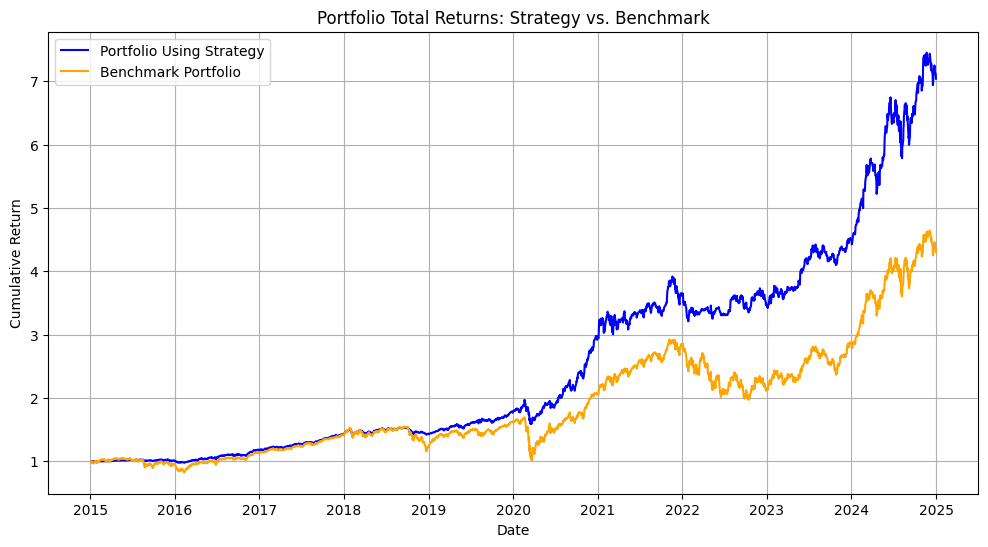

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def get_tickers():
    file_path = r"tickers.txt"
    with open(file_path, 'r') as file:
        content = file.read()
        tickers = content.replace("'", "").replace(",", "").split()
    return tickers

# Backtesting function
def backtest_strategy(data, short_window, long_window):
    # Calculate the short-term simple moving average (SMA) using the specified short_window
    data["SMA_short"] = data["Close"].rolling(window=short_window).mean()
    # Calculate the long-term simple moving average (SMA) using the specified long_window
    data["SMA_long"] = data["Close"].rolling(window=long_window).mean()

    # Generate trading signals: Signal is 1 (Buy) when the short SMA is greater than the long SMA
    data["Signal"] = 0
    data.loc[data["SMA_short"] > data["SMA_long"], "Signal"] = 1
    # Define the position (1 or 0) by shifting the signal by one day to avoid lookahead bias
    data["Position"] = data["Signal"].shift(1)

    # Strategy returns
    data["Daily_Return"] = data["Close"].pct_change().fillna(0)
    data["Strategy_Return"] = data["Position"] * data["Daily_Return"]

    # Cumulative returns for the strategy
    data["Cumulative_Strategy"] = (1 + data["Strategy_Return"]).cumprod()
    # Calculate cumulative returns for the benchmark (buy & hold strategy)
    data["Cumulative_Benchmark"] = (1 + data["Daily_Return"]).cumprod()

    return data

tickers = get_tickers()
print(f"Found {len(tickers)} tickers to evaluate.")

cumulative_strategy = pd.DataFrame()
cumulative_benchmark = pd.DataFrame()

# Loop through tickers and calculate cumulative returns
for ticker in tickers:
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)
    if "Adj Close" in data.columns:
        data["Close"] = data["Adj Close"]
    else:
        data["Close"] = data["Close"]

    # Random search for optimization
    random.seed(42)
    best_params = None
    best_performance = -np.inf

    # We loop through 100 iterations to perform a random search for parameters
    for _ in range(100):  
        short_window = random.randint(5, 50) # Generate a random short moving average window between 5 and 50 days
        long_window = random.randint(51, 200) # Generate a random long moving average window between 51 and 200 days
        if short_window >= long_window:
            continue

        # We perform a backtest on the data using the randomly generated short and long window parameters
        data_temp = backtest_strategy(data.copy(), short_window, long_window)
        sharpe_ratio = data_temp["Strategy_Return"].mean() / data_temp["Strategy_Return"].std() * (252**0.5)
        # Check if the current Sharpe ratio is better than the best performance found so far
        if sharpe_ratio > best_performance:
            # If so, update the best performance metric to the current Sharpe ratio
            best_performance = sharpe_ratio
            # Save the current parameters (short_window, long_window) as the best parameters
            best_params = (short_window, long_window)

    # Backtest using the best parameters
    data = backtest_strategy(data.copy(), best_params[0], best_params[1])

    cumulative_strategy[ticker] = data["Cumulative_Strategy"]
    cumulative_benchmark[ticker] = data["Cumulative_Benchmark"]

# Aggregate strategy cumulative returns
cumulative_strategy["Portfolio"] = cumulative_strategy.mean(axis=1)
cumulative_benchmark["Portfolio"] = cumulative_benchmark.mean(axis=1)

# Calculate overall strategy-level and benchmark-level performance
strategy_return = cumulative_strategy["Portfolio"].iloc[-1] - 1
benchmark_return = cumulative_benchmark["Portfolio"].iloc[-1] - 1

# Calculate annualized returns
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2025-01-01")
years = (end_date - start_date).days / 365.25

strategy_annualized_return = (1 + strategy_return) ** (1 / years) - 1
benchmark_annualized_return = (1 + benchmark_return) ** (1 / years) - 1

# Print performance metrics
print(f"Strategy Return (with equal weights for each stock): {strategy_return * 100:.2f}%")
print(f"Strategy Annualized Return: {strategy_annualized_return * 100:.2f}%")
print(f"Benchmark Return (Buy & Hold): {benchmark_return * 100:.2f}%")
print(f"Benchmark Annualized Return (Buy & Hold): {benchmark_annualized_return * 100:.2f}%")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy.index, cumulative_strategy["Portfolio"], label="Portfolio Using Strategy", color="blue")
plt.plot(cumulative_benchmark.index, cumulative_benchmark["Portfolio"], label="Benchmark Portfolio", color="orange")

plt.title("Portfolio Total Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)

plt.show()

